In [1]:
import os
# os.environ['KERAS_BACKEND'] = 'tensorflow'
import glob
import h5py
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from dask import delayed
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.preprocessing import standardize
import keras
from keras.models import Model
from keras.layers import (Input, Conv2D, MaxPooling2D, Cropping2D, Flatten,
                          Dense, Dropout)
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical

from livelossplot import PlotLossesKeras

import comptools as comp

output_notebook()
%matplotlib inline

/data/user/jbourbeau/miniconda/envs/cr-composition/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


Loading BokehJS ...

In [2]:
config = 'IC86.2012'
num_groups = 2

comp_list = comp.get_comp_list(num_groups=num_groups)
energybins = comp.get_energybins(config=config)
log_energy_min = energybins.log_energy_min
log_energy_max = energybins.log_energy_max

In [3]:
df_sim_train, df_sim_test = comp.load_sim(config=config,
                                          log_energy_min=log_energy_min,
                                          log_energy_max=log_energy_max,
                                          test_size=0.5,
                                          verbose=True)

[########################################] | 100% Completed |  2.4s


In [4]:
feature_list, feature_labels = comp.get_training_features()

In [5]:
feature_list += ['lap_x', 'lap_y']
feature_list

['lap_cos_zenith', 'log_s125', 'log_dEdX', 'lap_x', 'lap_y']

In [6]:
scaler = StandardScaler()
df_sim_train[feature_list] = scaler.fit_transform(df_sim_train[feature_list])
df_sim_test[feature_list] = scaler.transform(df_sim_test[feature_list])

In [6]:
# X = df_sim_train[feature_list].values
# y = df_sim_train['comp_target_{}'.format(num_groups)].values

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)

## Load charge distribution histograms

In [7]:
file_pattern = os.path.join(comp.paths.comp_data_dir,
                            config,
                            'sim',
                            'charge_dist_hdf',
                            '*.hdf')
file_pattern

'/data/user/jbourbeau/composition/IC86.2012/sim/charge_dist_hdf/*.hdf'

In [8]:
filenames = glob.glob(file_pattern)

In [9]:
len(filenames)

80

In [10]:
def generate_data(filenames, df_sim, features, labels, batchsize=3):
    
    batch_id = np.arange(len(df_sim)) // batchsize
    # Loop over indefinitley
    while True:
        for batch_idx, batch_df in df_sim.groupby(batch_id):

            X_batch = []
            targets_batch = []
            charge_dist_batch = []

            for file_idx, filename in enumerate(filenames):
                with h5py.File(filename, mode='r') as f:
                    array = f['/charge_dist'].value
                    event_id = f['/event_id'].value

                array = np.nan_to_num(array, copy=False)
                # Decode byte strings
                event_id = np.array([i.decode('utf-8') for i in event_id])

                #Get boolean array for events    
                pass_cuts_mask = np.isin(event_id, batch_df.index)
                if pass_cuts_mask.sum() == 0:
                    continue

                array_pass_cuts = array[pass_cuts_mask]
                event_id_pass_cuts = event_id[pass_cuts_mask]

                num_images = array_pass_cuts.shape[0]
                assert array_pass_cuts.shape[0] == event_id_pass_cuts.shape[0]

                # Normalize each image
                array_pass_cuts = array_pass_cuts / array_pass_cuts.reshape((num_images, -1)).sum(axis=1)[:, None, None]

                X_batch.extend(batch_df.loc[event_id_pass_cuts, features].values)
                targets_batch.extend(to_categorical(labels.loc[event_id_pass_cuts].values, num_classes=num_groups))
                charge_dist_batch.extend(array_pass_cuts)

            charge_dist_batch = np.asarray(charge_dist_batch)
            new_shape = tuple(list(charge_dist_batch.shape) + [1])
            charge_dist_batch = charge_dist_batch.reshape(new_shape)

            inputs = [charge_dist_batch, np.asarray(X_batch)]
            targets_batch= np.array(targets_batch)

            yield (inputs, targets_batch)

In [26]:
sample_generator = generate_data(filenames,
                                 df_sim_train.iloc[:100],
                                 feature_list,
                                 df_sim_train.iloc[:100]['comp_target_{}'.format(num_groups)],
                                 batchsize=10)

In [27]:
for inputs, targets in sample_generator:
    print('w')

w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w
w


KeyboardInterrupt: 

In [77]:
# dask_arrays = []
# for fn in filenames:
#     with h5py.File(fn, mode='r') as f:
#         d = f['/charge_dist'].value
# #         d = d / d.max()
#         d = np.nan_to_num(d)
#         d = np.array([i / i.sum() for i in d])
#     x = da.from_array(d, chunks=100)
#     dask_arrays.append(x)

# x = da.concatenate(dask_arrays, axis=0)  # concatenate arrays along first axis

In [79]:
# with ProgressBar() as _, Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
#     hists = x.compute(num_workers=20)

[########################################] | 100% Completed | 19.6s


Reshape charge distribution array for use in keras

In [83]:
# print(f'current_shape = {hists.shape}')
# new_shape = tuple(list(hists.shape) + [1])
# hists = hists.reshape(new_shape)
# print(f'new_shape = {hists.shape}')

current_shape = (1118562, 24, 24)
new_shape = (1118562, 24, 24, 1)


In [84]:
# dask_arrays = []
# for fn in filenames:
#     with h5py.File(fn, mode='r') as f:
#         d = f['/event_id'].value
#         # Byte strings
#         d = np.array([i.decode('utf-8') for i in d])
#     x = da.from_array(d, chunks=100)
#     dask_arrays.append(x)

# event_ids = da.concatenate(dask_arrays, axis=0)  # concatenate arrays along first axis

In [85]:
# with ProgressBar():
#     event_ids = event_ids.compute(num_workers=20)

[########################################] | 100% Completed | 20.9s


In [86]:
event_ids

array(['12630_10077_3_0', '12630_10077_7_0', '12630_10077_10_0', ...,
       '12630_1332_26_0', '12630_1332_86_0', '12630_1332_89_0'],
      dtype='<U16')

In [87]:
event_ids[0]

'12630_10077_3_0'

In [88]:
train_mask = np.array([item in df_sim_train.index for item in event_ids])
test_mask = np.array([item in df_sim_test.index for item in event_ids])

In [89]:
df_sim_train.index.shape, df_sim_test.index.shape

((35425,), (35426,))

In [90]:
df_sim_train.index.intersection(df_sim_test.index)

Index([], dtype='object')

In [91]:
np.sum(train_mask), np.sum(test_mask)

(35425, 35426)

In [92]:
hist_array_train = xr.DataArray(hists[train_mask], coords={'dim_0': event_ids[train_mask]})
hist_array_test = xr.DataArray(hists[test_mask], coords={'dim_0': event_ids[test_mask]})

In [93]:
hist_array_train

<xarray.DataArray (dim_0: 35425, dim_1: 24, dim_2: 24, dim_3: 1)>
array([[[[0.],
         ...,
         [0.]],

        ...,

        [[0.],
         ...,
         [0.]]],


       ...,


       [[[0.],
         ...,
         [0.]],

        ...,

        [[0.],
         ...,
         [0.]]]])
Coordinates:
  * dim_0    (dim_0) <U16 '12630_17688_29_0' '12630_8819_21_0' ...
Dimensions without coordinates: dim_1, dim_2, dim_3

In [94]:
hist_array_train = hist_array_train.loc[df_sim_train.index]
hist_array_test = hist_array_test.loc[df_sim_test.index]

/net/cvmfs_users/jbourbeau/miniconda/envs/cr-composition/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


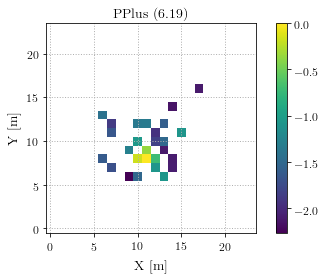

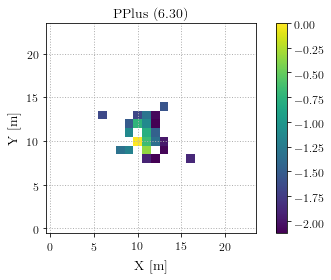

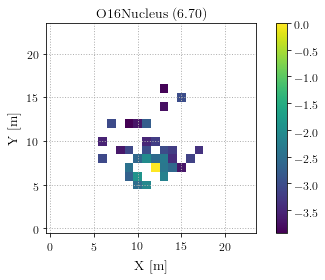

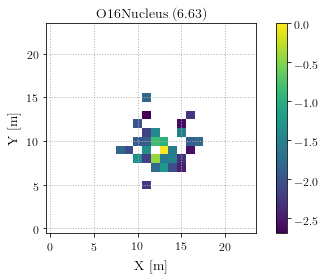

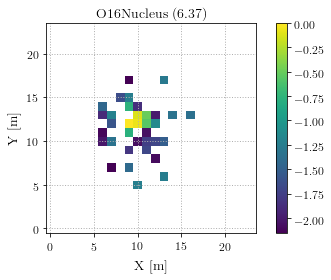

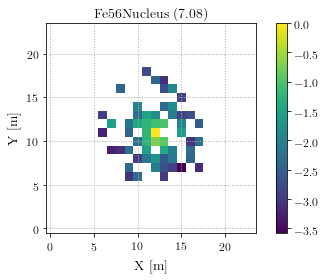

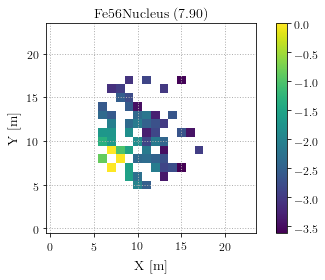

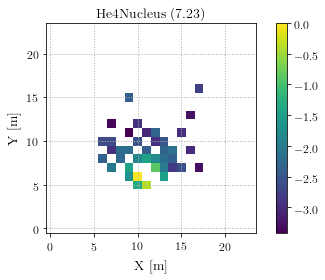

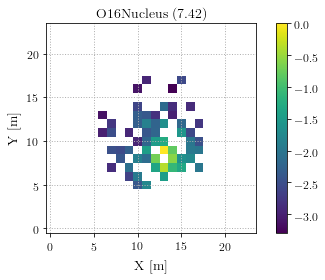

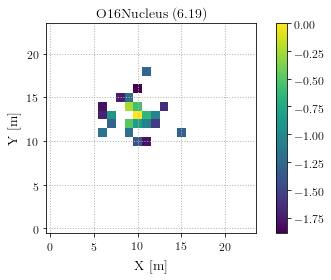

In [95]:
for idx in range(10):
    h = hist_array_train[idx].values
    h = h.reshape(new_shape[1:-1])
    h_norm = h / h.max()
    h_norm[h_norm == 0] = np.nan
#     plt.imshow(h_norm, origin='lower')
    plt.imshow(np.log10(h_norm), origin='lower')
    plt.colorbar()
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    true_comp = df_sim_train.iloc[idx]['MC_comp']
    true_log_energy = df_sim_train.iloc[idx]['MC_log_energy']
    plt.title(true_comp + ' ({:0.2f})'.format(true_log_energy))
    plt.grid()
    plt.show()

## CNN model

In [40]:
inputs = Input(shape=(24, 24, 1), name='hist_input')

x = Conv2D(12, (9, 9), padding='same')(inputs)
x = LeakyReLU(alpha=0.3)(x)
x = Conv2D(12, (9, 9), padding='same')(x)
x = LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(6, 6))(x)
x = Dropout(0.2)(x)

x = Conv2D(24, (9, 9), padding='same')(inputs)
x = LeakyReLU(alpha=0.3)(x)
x = Conv2D(24, (9, 9), padding='same')(x)
x = LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(6, 6))(x)
x = Dropout(0.2)(x)

# x = Conv2D(64, (3, 3), padding='same')(inputs)
# x = LeakyReLU(alpha=0.3)(x)
# x = Conv2D(64, (3, 3), padding='same')(x)
# x = LeakyReLU(alpha=0.3)(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.2)(x)

# x = Conv2D(128, (3, 3), padding='same')(inputs)
# x = LeakyReLU(alpha=0.3)(x)
# x = Conv2D(128, (3, 3), padding='same')(x)
# x = LeakyReLU(alpha=0.3)(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.2)(x)

flatten_output = Flatten()(x)

auxiliary_input = Input(shape=(len(feature_list),), name='aux_input')
x = keras.layers.concatenate([flatten_output, auxiliary_input])

x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

predictions = Dense(num_groups, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=[inputs, auxiliary_input], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hist_input (InputLayer)         (None, 24, 24, 1)    0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 24, 24, 24)   1968        hist_input[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_27 (LeakyReLU)      (None, 24, 24, 24)   0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 24, 24, 24)   46680       leaky_re_lu_27[0][0]             
__________________________________________________________________________________________________
leaky_re_l

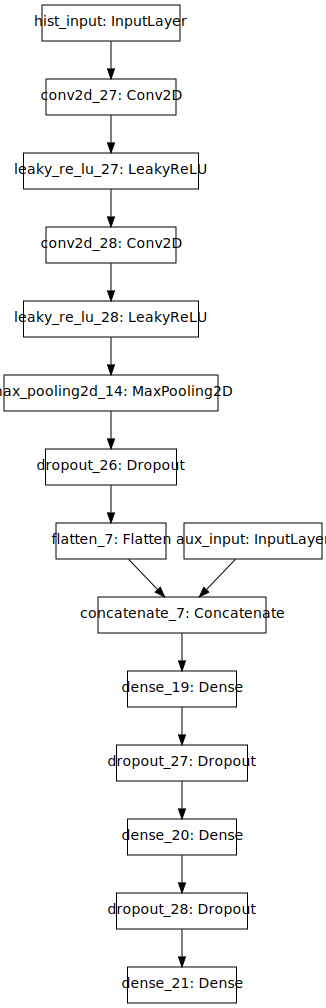

In [42]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [43]:
# X_stand = standardize(X)

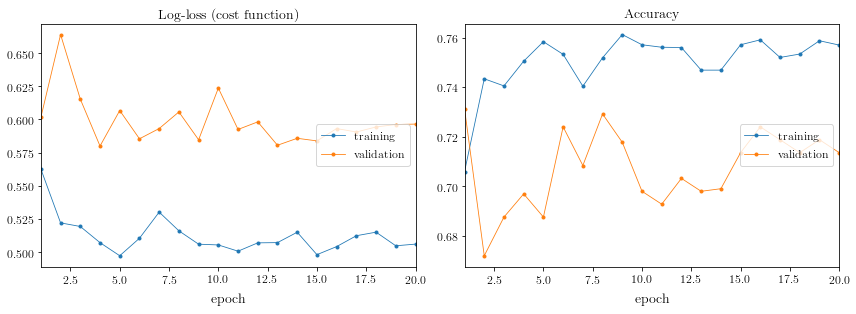

In [44]:
np.random.seed(2)
# n_samples = -1

batch_size = 64
train_sample = df_sim_train.sample(n=8000, random_state=2)
train_generator = generate_data(filenames,
                                train_sample,
                                feature_list,
                                train_sample['comp_target_{}'.format(num_groups)],
                                batchsize=batch_size)

test_sample = df_sim_test.sample(n=1000, random_state=2)
test_generator = generate_data(filenames,
                               test_sample,
                               feature_list,
                               test_sample['comp_target_{}'.format(num_groups)],
                               batchsize=batch_size)

steps_per_epoch = int(train_sample.shape[0] / batch_size)
validation_steps = int(test_sample.shape[0] / batch_size)

hist = model.fit_generator(train_generator,
                           validation_data=test_generator,
                           epochs=20,
                           steps_per_epoch=steps_per_epoch,
                           validation_steps=validation_steps,
                           use_multiprocessing=True,
                           workers=10,
                           callbacks=[PlotLossesKeras()])

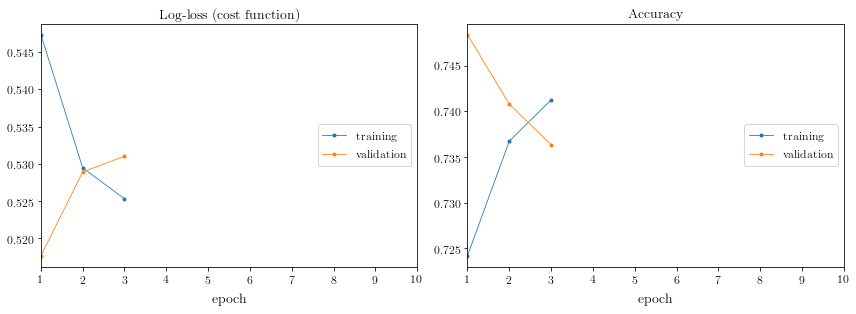

Epoch 4/10
 2560/24796 [==>...........................] - ETA: 9:42 - loss: 0.5258 - acc: 0.7336

In [ ]:
np.random.seed(2)
n_samples = -1
hist = model.fit([hist_array_train[:n_samples], X_stand[:n_samples]], y_cat[:n_samples],
                 epochs=10,
                 batch_size=128,
                 validation_split=0.3,
                 callbacks=[PlotLossesKeras()])

In [133]:
hist

In [134]:
hist.history

{'val_loss': [0.6119316350089179,
  0.5692388772964477,
  0.518451695839564,
  0.5022735868559943,
  0.509047027958764,
  0.5097404617733425,
  0.5062957449091805,
  0.5065806629260381,
  0.5081568378872342,
  0.5083513327439626],
 'val_acc': [0.69,
  0.7416666666666667,
  0.75,
  0.7438888888888889,
  0.7494444444444445,
  0.7411111111111112,
  0.74,
  0.7438888888888889,
  0.745,
  0.7427777777777778],
 'loss': [0.6671355778830392,
  0.5739729388554891,
  0.5567742087727501,
  0.530693727447873,
  0.5271891915230524,
  0.5248197971071515,
  0.5203457085291544,
  0.5181512903031849,
  0.527619998341515,
  0.5167634908358256],
 'acc': [0.5895238095238096,
  0.7114285721097674,
  0.7245238095238096,
  0.742380952494485,
  0.7354761911573864,
  0.7407142857142858,
  0.7402380956922259,
  0.748333333446866,
  0.7390476195017497,
  0.7435714289120265]}